# Adversarial Examples - LeNet on MNIST Data

Network on the development set of MNIST dataset. 10,000 images.


**Content**

1. Model and data
2. Predict function
3. Adversarial examples:

&emsp; 3.1 FGSM (untargeted)

&emsp; 3.2 BIM (untargeted)

&emsp; 3.3 Extension of BIM (targeted)

&emsp; 3.4 DeepFool (?)

In [2]:
## Imports
import numpy as np
import pandas as pd

from PIL import Image
import torch
import torch.nn as nn
from torchvision import models
from torchvision import datasets
import random

import torch.nn.functional as F

import matplotlib.pyplot as plt

from torchvision import transforms
import urllib

plt.rcParams['figure.figsize'] = (20.0, 10.0)

from IPython.display import clear_output

## 1. Load data and model

First we load the model and data.


### 1.1 Model

LeNet style

In [3]:
## Load model and data
pretrained_model = "models/lenet_mnist_model.pth"

## Define LeNet model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
## Initialize the network
model = Net()

## Load the pretrained model
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

## Set the model in evaluation mode. In this case this is for the Dropout layers
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### 1.2 Data

Loading the data into a PyTorch dataloader. Here we also integrate the scaling transformation step.

We also define the function `show_tensor_image`to display an image.

In [4]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=False)


## Get images and labels from dataloader
images = []
labels = []
data_test = []

for X, Y in data_loader:
    images.append(X)
    labels.append(Y) 

data_test.append(images)
data_test.append(labels)

In [5]:
def get_image_and_label(data_test, image_number="random"):
    '''
    Returns a random image and its label as float tensor objects
    
    Inputs:
    data_test  -- PyTorch dataloader with the MNIST data
    image_number -- Number of example to show. There are 10,000. Default is random
    
    Returns:
    image        -- Image as tensor of dimension (1, 1, 28, 28)
    label        -- Label as tensor of dimension (1)
    '''
      
    ## Extract images and labels
    images = data_test[0]
    labels = data_test[1]
        
    ## Determine sample number
    if image_number == "random":
        i = random.randrange(0, 10000)
    else:
        i = int(image_number)
    
    ## Extract selected sample
    image = images[i]
    label = labels[i]    
           
    ## Print image number
    print("Image number {} chosen\n".format(int(i)))
    
    
    return image, label

In [6]:
def show_tensor_image(tensor):
    '''
    Plots an image given as a tensor.
    
    Inputs:
    tensor -- image as tensor of dimension (1, 1, 28, 28)
    
    Returns:
    Plot of the image
    '''
    
    ## Check dimension
    assert(tensor.shape == torch.Size([1, 1, 28, 28]))
    
    ## Remove batch and channel dimension
    tensor = tensor.detach()
    tensor = tensor.squeeze(0).squeeze(0)

    ## Plot
    plt.imshow(tensor.numpy(), cmap="gray")

## 2. Predict

In [7]:
def predict(model, image, label, return_grad=False):
    '''
    Predicts the class of the given image and compares the prediction with the provided label.
    
    Inputs:
    model           -- net
    image           -- Input image as tensor of shape (1, 1, 28, 28)
    label           -- Target label as tensor of shape (1)
    return_grad     -- Returns gradient if set True
    
    Returns:
    gradient        -- None if return_grad=False. Otherwise the gradient from the prediction 
                       as a tensor of shape ()
    correct         -- Integer of value 1 if class is correct, otherwise 0
    confidence      -- Confidence of prediction
    predicted_label -- Predicted label
    '''
        
    if return_grad == True:
        image.requires_grad=True
        prediction = model(image)
               
        # Zero gradients
        model.zero_grad()

        # Calculate loss using the class index for pandas and get gradient
        loss = F.nll_loss(prediction, label)
        loss.backward()
        gradient = image.grad.data
        
    else:           
        gradient = None
        with torch.no_grad():
            prediction = model(image)
    
    ## Calculate if prediction is correct
    class_index = np.argmax(prediction.detach().numpy())
    
    if class_index == label:
        correct = 1
        
    else:
        correct = 0
     
    
    ## Get class index and confidence    
    prediction = torch.nn.functional.softmax(prediction[0].detach(), dim=0).numpy()
    confidence = prediction[class_index]
    
    ## Get class name from the predicted index
    predicted_label = np.argmax(prediction)
     
    return gradient, correct, confidence, predicted_label

## 3. Generate and Use Adversarial Examples

We now construct adversarial examples and use them to attack the network. We look at three untargeted attacks first. Finally, we investigate a targeted attack type. For more general information refer to the project overview.

To evaluate an individual adversarial example and to see it next to the clean image from which it has been constructed we define the function `plot_examples`.

In [1]:
def plot_examples(image_clean, image_adv, conf_clean, conf_adv, label_clean, label_adv, label_target):
    '''
    Plots the clean and adversarial image side-by-side. Prints predicted labels and confidences for both.
    
    Inputs:
    image_clean     -- Clean image as tensor of shape (1, 1, 28, 28)
    image_adv       -- Adversarial image as tensor of shape (1, 1, 28, 28)
    conf_clean      -- Confidence for the clean image
    conf_adv        -- Confidence for the adversarial image
    label_clean     -- Predicted label from the clean image
    label_adv       -- Predicted label from the adversarial image
    label_target    -- Target label as tensor of shape (1)
    '''
   
    ## Text
    print("\t\t\tClean image\t Adversarial image\n")
    print("Predicted class: \t{}\t\t\t{}".format(label_clean, label_adv ))
    print("Actual class: \t\t{}\t\t\t{}".format(label_target.detach().numpy()[0], label_target.detach().numpy()[0] ))
    print("Confidence: \t\t{:.2f}%\t\t\t{:.2f}%\n".format(conf_clean*100, conf_adv*100))
    
    ## Plots
    plt.subplot(121)
    plt.title("Clean example", fontsize=30)
    show_tensor_image(image_clean)
    plt.subplot(122)
    plt.title("Adversarial example", fontsize=30)
    show_tensor_image(image_adv)

### 3.1 Fast Gradient Sign Method


**TODO**
Add better description!!!!!!


This method by [1] generates adversarial examples quickly. It computes a step of gradient descent and moves one step of magnitude $\epsilon$ into the direction of this gradient:

\begin{equation}
\tag{1.1}
\widetilde{x} = x + \eta
\end{equation}

\begin{equation}
\tag{1.2}
\eta = \epsilon \cdot sign(\nabla_{x} J(\Theta, x, y))
\end{equation}


In [ ]:
def generate_adversarial_fgsm(image, epsilon, grad_x):
    '''
    Applies FGSM attack on input image.
    
    Inputs:
    image       -- Image data as tensor
    epsilon     -- Hyperparameter
    grad_x      -- Gradient of the cost with respect to x
    
    Returns:
    image_tilde -- Adversarial image as tensor
    '''
    
    ## Compute eta part
    eta = epsilon * grad_x.sign()
    
    ## Apply perturbation
    image_tilde = image + eta
    
    return image_tilde

Image number 2743 chosen

			Clean image	 Adversarial image

Predicted class: 	5			5
Actual class: 		5			5
Confidence: 		44.42%			40.99%



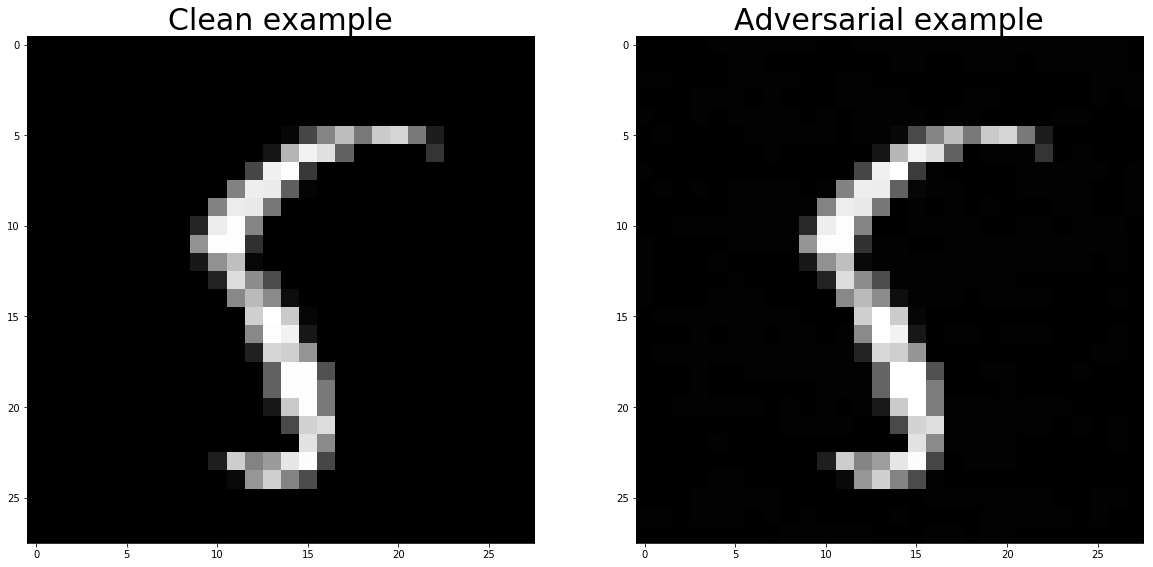

In [10]:
## Random example for smaller epsilon
epsilon = 1/255

image_clean, label = get_image_and_label(data_test, image_number=2743)

## Predict for clean image
gradient, _, conf_clean, name_clean = predict(model, image_clean, label, return_grad=True)

## Compute adversarial image and predict for it.
image_adv = generate_adversarial_fgsm(image_clean, epsilon, gradient)
_, _, conf_adv, name_adv = predict(model, image_adv, label, return_grad=False)

## Plot
plot_examples(image_clean, image_adv, conf_clean, conf_adv, name_clean, name_adv, label)

Image number 2743 chosen

			Clean image	 Adversarial image

Predicted class: 	5			8
Actual class: 		5			5
Confidence: 		44.42%			47.86%



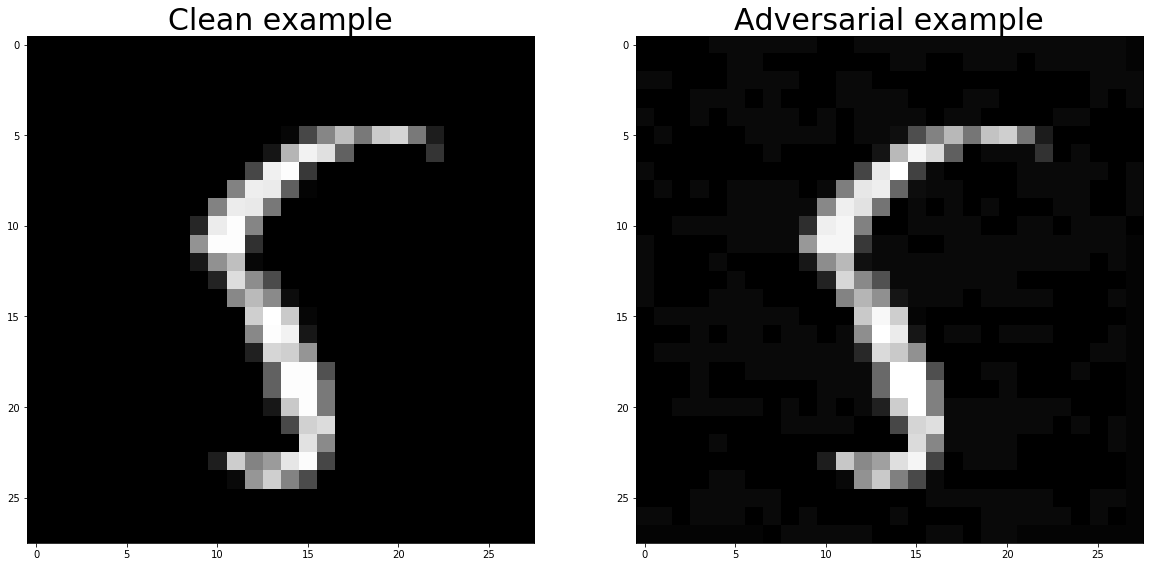

In [11]:
## Random example for larger epsilon
epsilon = 5/255

image_clean, label = get_image_and_label(data_test, image_number=2743)


## Predict for clean image
gradient, _, conf_clean, name_clean = predict(model, image_clean, label=label, return_grad=True)

## Compute adversarial image and predict for it.
image_adv = generate_adversarial_fgsm(image_clean, epsilon, gradient)
_, _, conf_adv, name_adv = predict(model, image_adv, label=label, return_grad=False)

## Plot
plot_examples(image_clean, image_adv, conf_clean, conf_adv, name_clean, name_adv, label)

Example `2743`: The clean example predicts the correct class `5` with a confidence of around $44%$. At $\epsilon=1/255$ the correct class is predicted with a confidence of around $41%$. A slight increase to $\epsilon=2/255$ seems to push the example past the decision boundary. The predicted class is `8` with a confidence of $42%$. Further increase to $10/255$ makes the prediction for class `8` more confident of up to $53%$. Further increase of epsilon makes the prediction even more confident. However, changes to the image become perceptible.





** TODO **





As can be seen, for cetrain values of $\epsilon$ the perturbations are clearly visable to the human eye. At the same time, the examples are still mostly classified as the correct class, however at a lower confidence (first example, here sample `3441`).

For $\epsilon = 20/255$ sample number `6101` is an example for a desirable adversarial input. The predicted class is `1` with a confidence of $100$% in the clean case. The perturbed image is predicted as `8` with a confidence of around $70$%.

Next we generate adversarial inputs with different values of $\epsilon$ and compute the average accuracy and confidence on all data.

In [12]:
## Run on all 10000 examples
epsilons = [0, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]

accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

for epsilon in epsilons:
   
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    i = 1
    
    for image_as_tensor, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon))
        print("Sample: " + str(i))
        print("Average adv. accuracy: {:.2f}\nAverage adv. confidence: {:.2f}".format(np.mean(acc_sub_adver), np.mean(np.mean(conf_sub_adver) )) )
        
        ## Predict with clean image
        gradient, acc, conf, _ = predict(model, image_as_tensor, label=label, return_grad=True)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        perturbed_data = generate_adversarial_fgsm(image_as_tensor, epsilon, gradient)
        _, acc, conf, _ = predict(model, perturbed_data, label=label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        i += 1

    ## Add accuracies and confidences
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))
    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))


## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Accuracy"] = accuracy_adversarial
result["Confidence"] = confidence_adversarial
result.to_csv("results/LeNet_MNIST_FGSM_2.csv")

Running for epsilon 0.35
Sample: 10000
Average adv. accuracy: 0.02
Average adv. confidence: 0.31


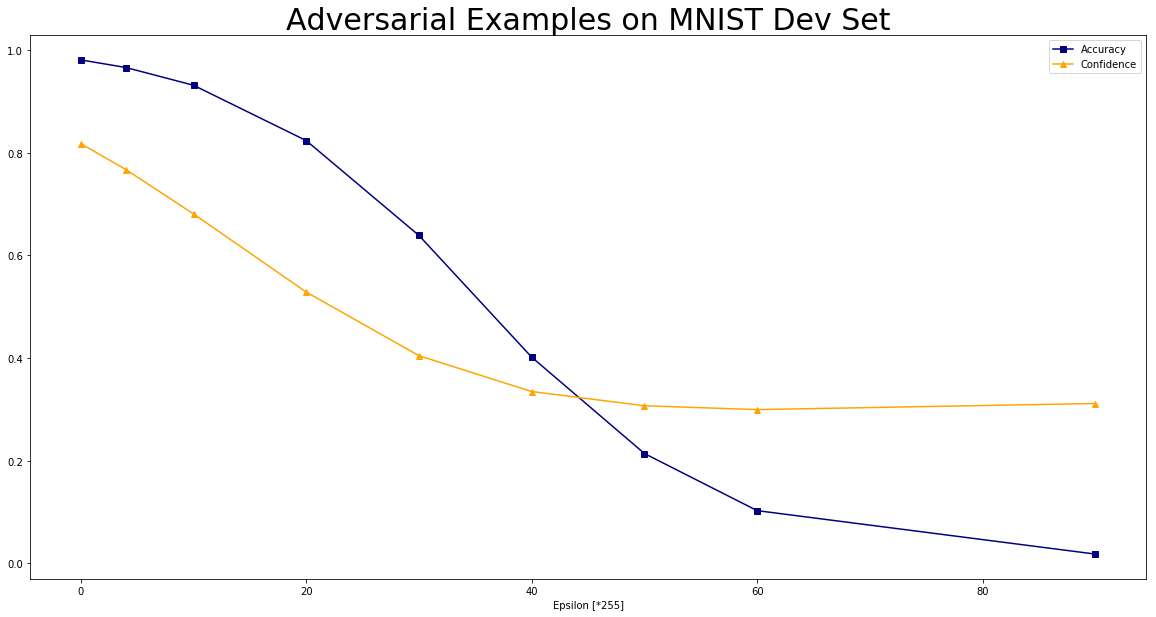

In [14]:
plt.plot(e, accuracy_adversarial, "s-", color="navy", label="Accuracy")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples on MNIST Dev Set", fontsize=30)
plt.legend()
#plt.show()

#plt.savefig("Adversarial_Examples_MNIST_FGSM_2.pdf")
#plt.savefig("Adversarial_Examples_MNIST_FGSM_2.png")

### 3.2 Basic Iterative Method (BIM)

In the previous section we found examples which are classified as the wrong class at a high confidence using the FGSM. A downside of FGSM is that it can be used for untargeted attacks only [2]. Another downside is that



BIM requires the following function, which clips pixel values of an image $X^\prime$:

**TODO**
Fix explanation!!

Similar to the fast method we update the pixel values:

\begin{equation}
\tag{2.1}
\widetilde{X}_{n+1} = Clip_{X, \epsilon} \{ \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true})) \}
\end{equation}




Here, the Clip function is defined as:

\begin{equation}
\tag{2.2}
Clip_{X, \epsilon} \{ X^\prime \} (x, y, z) = min\{ 255, X(x, y, z) + \epsilon, max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \} \}
\end{equation}

For the implementation we initialize:

\begin{equation}
\tag{2.3}
\widetilde{X}_{0} = X
\end{equation}

For the implementation we do for the number of iterations `n`:


a) Compute $ X^\prime = \widetilde{X}_{n} + \alpha sign(\nabla_{X} J(\widetilde{X}_{n}, Y_{true}))$ as used in equation (2.1)

b) Compute $ X(x, y, z) + \epsilon $ and $ X(x, y, z) - \epsilon $

c) Evaluate equation (2.2) using steps a) and b)

$max\{0, X(x, y, z)-\epsilon, X^\prime(x, y, z) \}$ (?)

d) Retrieve updated adversarial image $\widetilde{X}_{1}$ as given in equation (2.1)

Values for the hyper parameters given in [2]:

- $\alpha = 1$

- Number of iterations: $min(4+\epsilon, 1.25 \cdot \epsilon)$

- $\epsilon $

In [12]:
def apply_BIM(model, image, label, alpha, epsilon, num_iterations=2):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    model          -- Model under attack
    image          -- Image data as tensor of shape (1, 1, 28, 28)
    label          -- Label from image as tensor of shape (1)
    alpha          -- Hyperparameter for iterative step??
    epsilon        -- Hyperparameter for sign method???
    num_iterations -- Number of iterations to perform
    
    Returns:
    image_adver    -- Adversarial image as tensor of shape (1, 1, 28, 28)
    '''   
    
    ## Check input image and label shapes
    assert(image.shape == torch.Size([1, 1, 28, 28]))
    assert(label.shape == torch.Size([1]))
    
    ## Initialize adversarial image as image according to equation (3)
    image_adver = image.clone()    
    
    for i in range(num_iterations):
        
        ## Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        ## Compute cost with example image_adersarial to get gradient. Make sure gradient is not None             
        pred = model(image_adver)                
        loss = F.nll_loss(pred, label)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        assert(image_adver.grad is not None)
              
        ## Compute X_prime according to equation (1)
        image_prime = image_adver + alpha * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
    
        ## Apply clip function to image_prime as in equation (2)       
        image_plus = image + epsilon
        image_minus = image - epsilon
        assert(torch.equal(image_plus, image) == False)
        
        # Equation 1.2
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(torch.tensor(0, dtype=torch.float), third_part_1)
              
        # Equation (2)
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(torch.tensor(255, dtype=torch.float), image_adver)                        

    
    return image_adver

Number of iterations: 1
Image number 4407 chosen

			Clean image	 Adversarial image

Predicted class: 	9			9
Actual class: 		9			9
Confidence: 		85.70%			74.55%



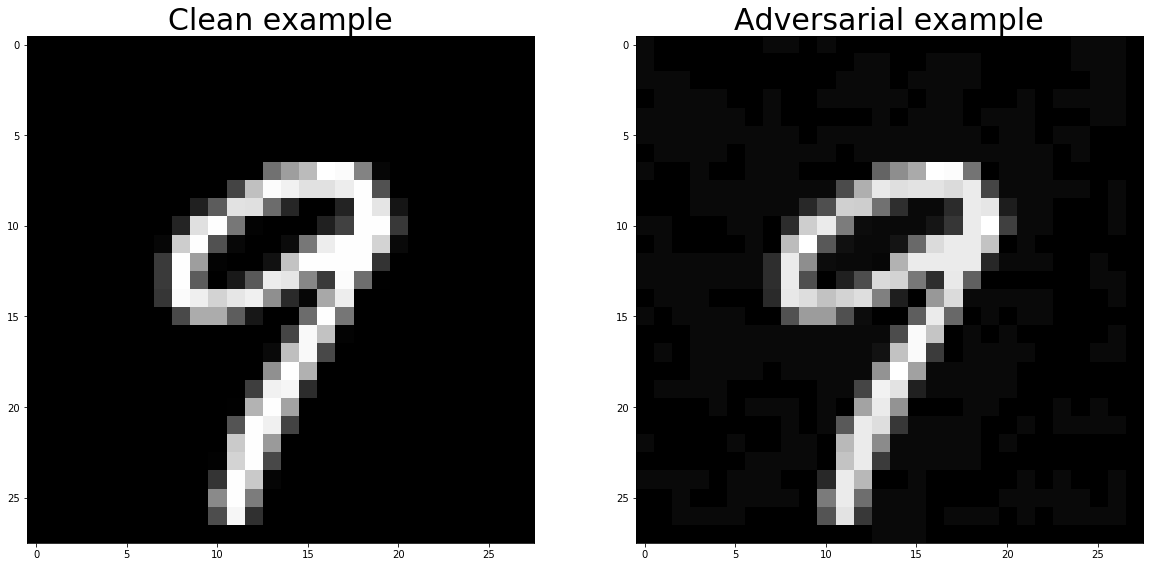

In [90]:
epsilon = 10/255 ## 
alpha = 1 # As in the paper
num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
print("Number of iterations: " + str(num_iterations))

image_clean, label = get_image_and_label(data_test, image_number='random')
image_adv = apply_BIM(model, image_clean, label, alpha, epsilon, num_iterations=num_iterations)

## Predictions
_, _, conf_clean, name_clean = predict(model, image_clean, label=label, return_grad=False)
_, _, conf_adv, name_adv = predict(model, image_adv, label=label, return_grad=False)

## Plot
plot_examples(image_clean, image_adv, conf_clean, conf_adv, name_clean, name_adv, label)

In [16]:
## BIM: Run on all 10000 examples
epsilons = [0, 4/255, 10/255, 20/255, 30/255, 40/255, 50/255, 60/255, 90/255]

alpha = 1 # As in the paper
num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
print("Number of iterations: " + str(num_iterations))


num_iter = []

accuracy = []
confidence = []

accuracy_adversarial = []
confidence_adversarial = []

for epsilon in epsilons:
   
    num_iterations = int(np.min([np.ceil(epsilon*4), np.ceil(1.25+epsilon)]))
    num_iter.append(num_iterations)
    
    acc_sub = []
    conf_sub = []
    acc_sub_adver = []
    conf_sub_adver = []
    i = 1
    
    for image_clean, label in data_loader:      
        clear_output(wait=True)
        print("Running for epsilon {:.2f}".format(epsilon))
        print("Sample: " + str(i))
        print("Number of iterations: " + str(num_iterations))
        print("Average adv. accuracy: {:.2f}\nAverage adv. confidence: {:.2f}".format(np.mean(acc_sub_adver), np.mean(np.mean(conf_sub_adver) )) )
        
        ## Predict with clean image
        _, acc, conf, _ = predict(model, image_clean, label=label)
        acc_sub.append(acc)
        conf_sub.append(conf)

        ## Predict with adversarial image
        image_adversarial = apply_BIM(model, image_clean, label, alpha, epsilon, num_iterations=num_iterations)
        _, acc, conf, _ = predict(model, image_adversarial, label=label)
        acc_sub_adver.append(acc)
        conf_sub_adver.append(conf)
        i += 1

    ## Add accuracies and confidences
    accuracy.append(np.mean(acc_sub))
    confidence.append(np.mean(conf_sub))
    accuracy_adversarial.append(np.mean(acc_sub_adver))
    confidence_adversarial.append(np.mean(conf_sub_adver))


## Save results
result = pd.DataFrame()
e = np.array(epsilons) * 255
result["Epsilon_255"] = e
result["Num_Iter"] = num_iter
result["Accuracy"] = accuracy_adversarial
result["Confidence"] = confidence_adversarial
result.to_csv("results/LeNet_MNIST_BIM.csv")

Running for epsilon 0.35
Sample: 10000
Number of iterations: 2
Average adv. accuracy: 0.11
Average adv. confidence: 0.34


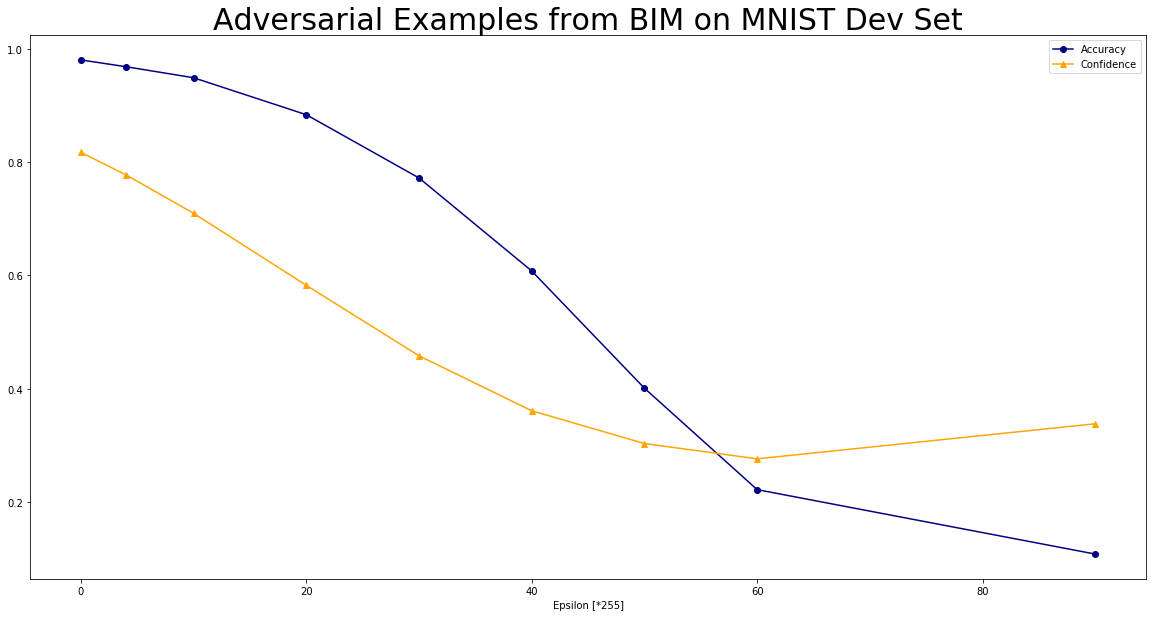

In [17]:
plt.plot(e, accuracy_adversarial, "o-", color="navy", label="Accuracy")
plt.plot(e, confidence_adversarial, "^-", color="orange", label="Confidence")
plt.xlabel("Epsilon [*255]")

plt.title("Adversarial Examples from BIM on MNIST Dev Set", fontsize=30)
plt.legend()
#plt.show()

plt.savefig("plots/LeNet_MNIST/Adversarial_Examples_MNIST_BIM.pdf")
plt.savefig("plots/LeNet_MNIST/Adversarial_Examples_MNIST_BIM.png")

### 3.3 DeepFool

### 3.4 Targeted Stuff

## 4. Conclusions

Some deep conclusions here ...

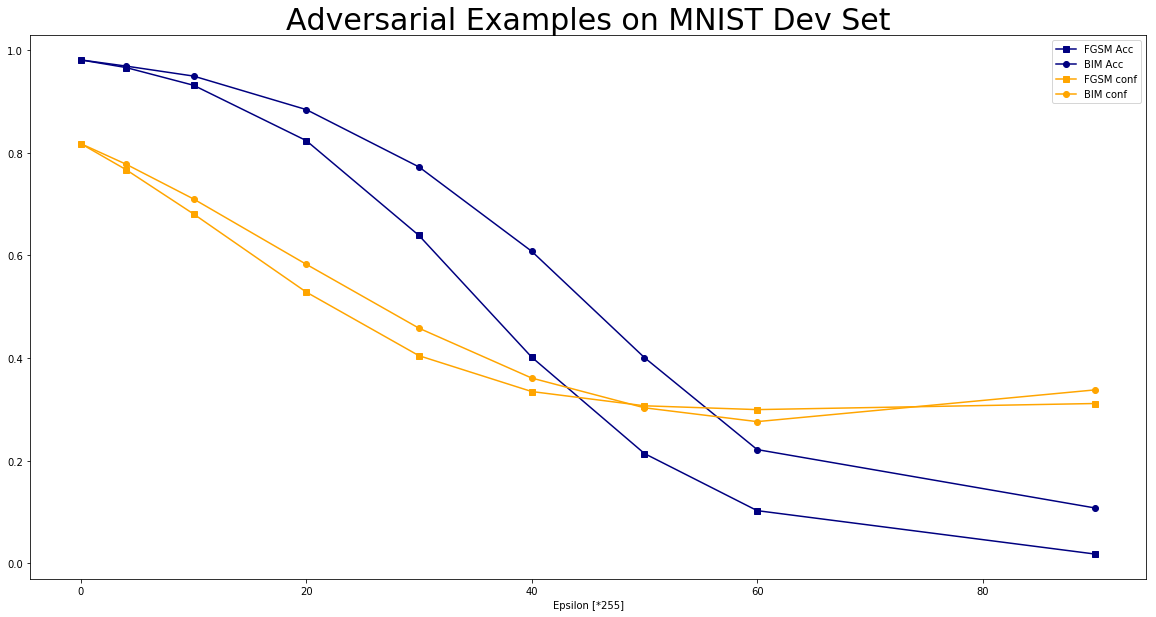

In [23]:
## Plot both FGSM and BIM
## Load data
fgsm = pd.read_csv("results/LeNet_MNIST_FGSM.csv")
bim = pd.read_csv("results/LeNet_MNIST_BIM.csv")

## Plot accuracy
plt.title("Adversarial Examples on MNIST Dev Set", fontsize=30)
plt.plot(e, fgsm["Accuracy"], "s-", color="navy", label="FGSM Acc")
plt.plot(e, bim["Accuracy"], "o-", color="navy", label="BIM Acc")

## Plot confidence
plt.plot(e, fgsm["Confidence"], "s-", color="orange", label="FGSM conf")
plt.plot(e, bim["Confidence"], "o-", color="orange", label="BIM conf")
plt.xlabel("Epsilon [*255]")
plt.legend()

plt.savefig("plots/LeNet_MNIST/Adversarial_Examples_MNIST_all.pdf")
plt.savefig("plots/LeNet_MNIST/Adversarial_Examples_MNIST_all.png")

## References

[1] &emsp; Goodfellow et al. (2015) *Explaining and Harnessing Adversarial Examples*

[2] &emsp; Kurakin et al. (2017) *Adversarial examples in the physical world*